<a href="https://colab.research.google.com/github/iw30/UHS-COVID-Testing/blob/main/INDENG_174_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Project Description**

Our project will focus primarily on simulating COVID testing environments run by the University Health Services at UC Berkeley. We are simulating two different COVID testing environments: Surveillance test in Rec Sport Facility (RSF), and Symptomatic and Exposure test in Durant side. The goals of the project are to: 
1. better understand the design of the current COVID testing environment
2. identify and address any inefficiencies in the system that contribute to longer wait times in the physical testing environments and/or the process needed from the point of the test to getting the result to the client.
3. optimize the system by minimizing waiting time and attack any bottlenecks occur on the system. 


There are two COVID testing layouts that we need to consider. First layout is for surveillance testing. Second layout is for symptomatic and exposure testing (i.e., symptomatic testing and exposure testing occur at the same place). Our goal here is to minimize the waiting time such that the total time the person in the system is less than 15 minutes. Also, the number of staff is limited to 15 staff and 5 staff in the first layout and second layout respectively. This is to limit COVID exposure for both students and staff.


# **Importing Data**

For the data in excel, link : https://docs.google.com/spreadsheets/d/1r0OSJAjtWXrpHpcyUow_TZL6tYa3ul_D/edit?usp=sharing&ouid=102202967501889999759&rtpof=true&sd=true

Before proceeding, download the data from the link above and put the data into the files tab.

The timeframe of the data is from January 1, 2021 up to October, 20 2021.

In [8]:
path = "/content/drive/MyDrive/INDENG 174/PROJECT INDENG 174/UHS COVID TESTING DATA.xlsx"

The data below relates to COVID testing:

In [9]:
collect_na = {"Count Collected":0}

In [10]:
# Data from sheet "Test Collected - Exposure"

df_collect_exp = pd.read_excel(path, sheet_name = "Tests Collected - Exposure").fillna(value = collect_na)
df_collect_exp = df_collect_exp.rename(columns = {"Count Collected":"Count Collected Exposure"\
                                                  ,"Average Days to Result":"Avg Days Result Exposure"})
df_collect_exp.head()

,Collection Date,Patient Type,Count Collected Exposure,Avg Days Result Exposure
0,2021-01-01,Total,0.0,NaN
1,2021-01-01,Faculty / Staff,0.0,NaN
2,2021-01-01,Grad,0.0,NaN
3,2021-01-01,Undergrad,0.0,NaN
4,2021-01-04,Total,0.0,NaN


In [11]:
# Data from sheet "Test Collected - Symptoms"

df_collect_sym = pd.read_excel(path, sheet_name = "Test Collected - Symptoms").fillna(value = collect_na)
df_collect_sym = df_collect_sym.rename(columns = {"Count Collected":"Count Collected Symptoms"\
                                                  ,"Average Days to Result":"Avg Days Result Symptoms"})
df_collect_sym.head()

,Collection Date,Patient Type,Count Collected Symptoms,Avg Days Result Symptoms
0,2021-01-01,Total,0.0,NaN
1,2021-01-01,Faculty / Staff,0.0,NaN
2,2021-01-01,Grad,0.0,NaN
3,2021-01-01,Undergrad,0.0,NaN
4,2021-01-04,Total,0.0,NaN


In [12]:
# Data from sheet "Test Collected - Surveillance"

df_collect_surv = pd.read_excel(path, sheet_name = "Test Collected-Surveillance").fillna(value = collect_na)
df_collect_surv = df_collect_surv.rename(columns = {"Count Collected":"Count Collected Surveillance"\
                                                  ,"Average Days to Result":"Avg Days Result Surveillance"})
df_collect_surv.head()

,Collection Date,Patient Type,Count Collected Surveillance,Avg Days Result Surveillance
0,2021-01-01,Total,107.0,4.009346
1,2021-01-01,Faculty / Staff,4.0,4.000000
2,2021-01-01,Grad,3.0,4.000000
3,2021-01-01,Undergrad,100.0,4.010000
4,2021-01-04,Total,197.0,2.000000


Data below relates to positive cases:

In [13]:
# Data from sheet "Positive Test - Exposure"

df_case_exp = pd.read_excel(path, sheet_name = "Positive Test - Exposure")\
.fillna(0)\
.rename(columns = {"Positive Result Count": "Positive Count Exposure"})
df_case_exp.head()

,Result Date,Patient Type,Positive Count Exposure
0,2021-01-05,Total,0.0
1,2021-01-05,Faculty / Staff,0.0
2,2021-01-05,Grad,0.0
3,2021-01-05,Undergrad,0.0
4,2021-01-06,Total,3.0


In [14]:
# Data from sheet "Positive Test - Symptoms"

df_case_sym = pd.read_excel(path, sheet_name = "Positive Test - Symptoms")\
.fillna(0)\
.rename(columns = {"Positive Result Count": "Positive Count Symptoms" })
df_case_sym.head()

,Result Date,Patient Type,Positive Count Symptoms
0,2021-01-05,Total,0.0
1,2021-01-05,Faculty / Staff,0.0
2,2021-01-05,Grad,0.0
3,2021-01-05,Undergrad,0.0
4,2021-01-06,Total,7.0


In [15]:
# Data from sheet "Positive Test - Surveillance"

df_case_surv = pd.read_excel(path, sheet_name = "Positive Test - Surveillance")\
.fillna(0)\
.rename(columns = {"Positive Result Count": "Positive Count Surveillance"})
df_case_surv.head()

,Result Date,Patient Type,Positive Count Surveillance
0,2021-01-05,Total,1.0
1,2021-01-05,Faculty / Staff,0.0
2,2021-01-05,Grad,0.0
3,2021-01-05,Undergrad,1.0
4,2021-01-06,Total,1.0


# **Predicting COVID cases**

Using time series analysis, we want to predict the number of COVID cases in UC Berkeley from October, 21 2021 until December, 31 2021. We have the data `df_case_exp`, `df_case_sym`, `df_case_surv` containing the number of positive cases in Berkeley for each testing place. Our expectation is that if the number of people tested positive from the previous day is high, then the next day the number of people requesting COVID testing is also high. Hence, after conducting time series analysis, we have the data for 1 year (January, 1 2021 until December, 31 2021).

In the code below, we want to obtain the table about the total COVID cases from each date.

In [16]:
df_case = pd.concat([df_case_exp,df_case_sym,df_case_surv], join = "outer", axis = 1)
df_case = df_case.iloc[:,~df_case.columns.duplicated()]
df_case['Total Positive Count'] = df_case['Positive Count Exposure'] + \
df_case['Positive Count Symptoms'] + df_case['Positive Count Surveillance']
df_case = df_case.head(1303)
df_case.head()

,Result Date,Patient Type,Positive Count Exposure,Positive Count Symptoms,Positive Count Surveillance,Total Positive Count
0,2021-01-05,Total,0.0,0.0,1.0,1.0
1,2021-01-05,Faculty / Staff,0.0,0.0,0.0,0.0
2,2021-01-05,Grad,0.0,0.0,0.0,0.0
3,2021-01-05,Undergrad,0.0,0.0,1.0,1.0
4,2021-01-06,Total,3.0,7.0,1.0,11.0


We pivot the data. This pivot table will be used on the next graph.

In [17]:
df_case_count = df_case.copy()
df_case_count['Result Date'] = pd.to_datetime(df_case_count['Result Date'])
df_case_count = df_case_count.pivot(index = "Result Date", columns = "Patient Type", values = "Total Positive Count").reset_index()
df_case_count = df_case_count.fillna(0)
df_case_count

Patient Type,Result Date,Faculty / Staff,Grad,Other,Total,Undergrad
0,2021-01-05,0.0,0.0,0.0,1.0,1.0
1,2021-01-06,0.0,1.0,0.0,11.0,10.0
2,2021-01-07,4.0,2.0,0.0,13.0,7.0
3,2021-01-08,2.0,5.0,0.0,14.0,7.0
4,2021-01-09,2.0,2.0,0.0,7.0,3.0
...,...,...,...,...,...,...
266,2021-10-16,0.0,0.0,0.0,1.0,1.0
267,2021-10-17,0.0,0.0,0.0,0.0,0.0
268,2021-10-18,1.0,1.0,0.0,4.0,2.0
269,2021-10-19,0.0,2.0,0.0,8.0,6.0


We plot the total number of positive cases in UC Berkeley. You can hover your mouse into the bar graph for data:

In [18]:
fig_count = px.bar(df_case_count, x= 'Result Date', y = 'Total', \
                   title = "Total Positive Cases", hover_data = ['Faculty / Staff','Grad','Undergrad','Other'])
fig_count.show()

The plot above is too crowded. We plot the boxplot showing the Positive Cases month-wise. 

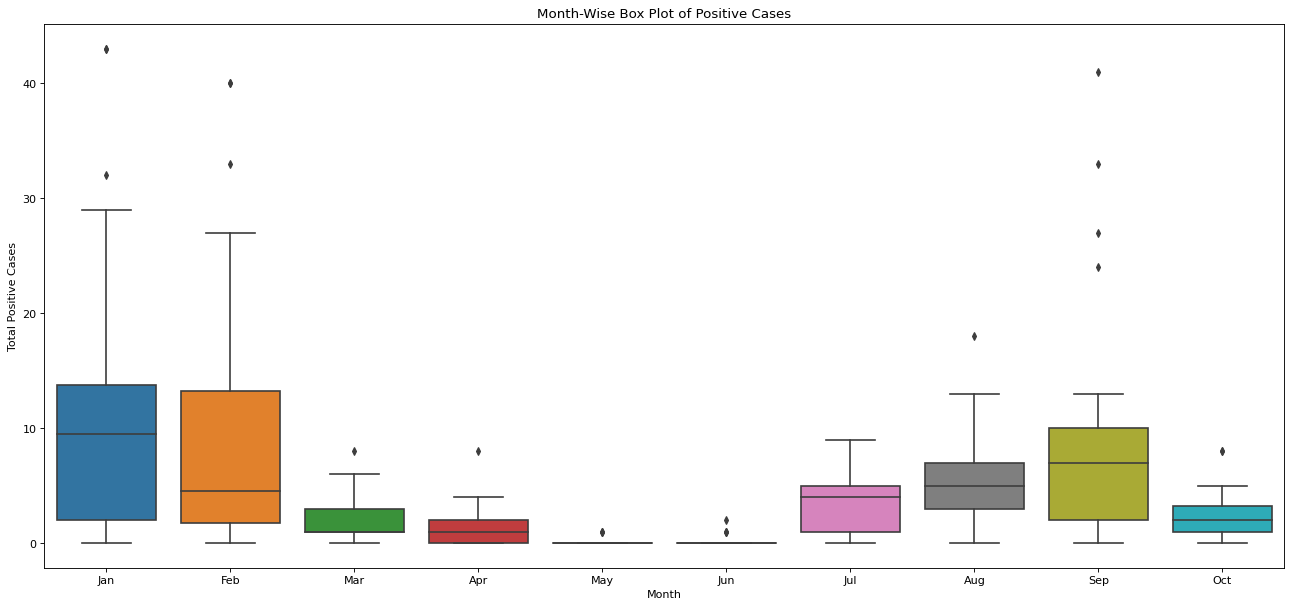

In [19]:
df_case_count['month'] = [d.strftime('%b') for d in df_case_count['Result Date']]

fig, axes = plt.subplots(1, figsize=(20,9), dpi= 80)
sns.boxplot(x='month', y='Total', data=df_case_count, ax = axes)
plt.title("Month-Wise Box Plot of Positive Cases")
plt.xlabel("Month")
plt.ylabel("Total Positive Cases");

Now, we start to use time series analysis to predict the number of positive cases in Berkeley. We are using fbprophet to conduct the time series analysis.

In [20]:
import fbprophet

In [21]:
# ds = Date, y = Total number of positive COVID cases
df_case_count_pred = df_case_count.rename(columns = {'Result Date':'ds','Total':'y'})[['ds','y']]
df_case_count_pred.head()

Patient Type,ds,y
0,2021-01-05,1.0
1,2021-01-06,11.0
2,2021-01-07,13.0
3,2021-01-08,14.0
4,2021-01-09,7.0


In [22]:
# Make the prophet model and fit on the data
# changepoint_prior_scale is how sensitive the trend is to change

prophet = fbprophet.Prophet()
prophet.fit(df_case_count_pred)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
# Make a future dataframe from October 21, 2021 until December 31, 2021
df_forecast = prophet.make_future_dataframe(periods=72, freq='D')
# Make predictions
df_forecast = prophet.predict(df_forecast)

Below is the plot of total number of positive case predicted until December, 31 2021. The black dot represents the real data, the blue region represents the confidence interval. The blue line represents predicted value.

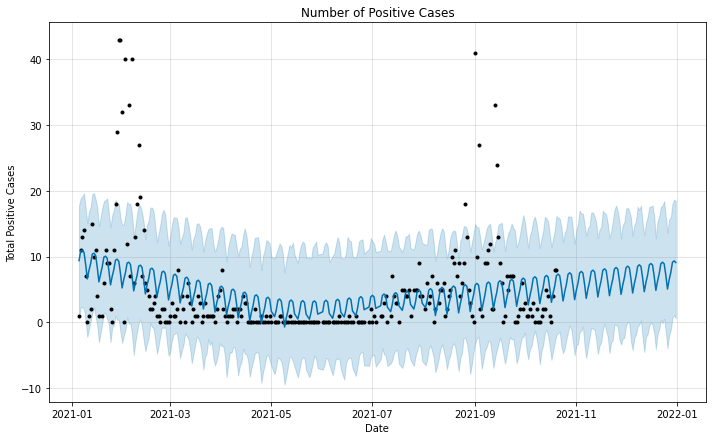

In [24]:
prophet.plot(df_forecast, xlabel = 'Date', ylabel = 'Total Positive Cases')
plt.title("Number of Positive Cases");

Below is the table containing the predicted total number of cases from October 21, 2021 to December 31, 2021. To predict the number of positive cases, we used a confidence interval and sample from the confidence interval for each date using uniform distribution. We decided to use the lower blue region for the lower confidence interval and the blue line as the upper confidence confidence interval. We decided to not use the upper blue region as the upper limit of confidence interval because >95% of the students in Berkeley have already been vaccinated, so our prediction is that COVID in the future won't rise significantly.

In [25]:
# Obtaining forecast dataframe
df_case_forecast = df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Slicing total number of cases from October 21,2021 to December 31,2021
df_case_forecast = df_case_forecast[df_case_forecast['ds'] > "2021-10-20"]

# Replacing all negative numbers with zero
num = df_case_forecast._get_numeric_data()
num[num < 0] = 0

# Start predicting total number of cases by using choosing uniformly from
# lower bound and upper bound
yhat_lower = df_case_forecast.reset_index()['yhat_lower'] # Lower bound
yhat_upper = df_case_forecast.reset_index()['yhat'] # Upper bound
yhat_list = []
np.random.seed(88) # For reproducibility purposes

for i in range(len(yhat_lower)):
  yhat = np.random.uniform(low = yhat_lower[i], high = yhat_upper[i], size = 1).round()
  yhat_list.append(yhat)

df_case_forecast['Total'] = yhat_list
df_case_forecast['Total'] = df_case_forecast['Total'].explode()
df_case_forecast = df_case_forecast.reset_index()[['ds','Total']].rename(columns = {'ds': 'Result Date'})
df_case_forecast

,Result Date,Total
0,2021-10-21,5
1,2021-10-22,4
2,2021-10-23,3
3,2021-10-24,3
4,2021-10-25,3
...,...,...
67,2021-12-27,1
68,2021-12-28,5
69,2021-12-29,4
70,2021-12-30,3


In [26]:
# Accouting "breakout" in the positive COVID cases
# Breakout is predicted to be December when Fall Semester ends

np.random.seed(88) # For reproducibility purposes

df_case_forecast.loc[62:64,'Total'] = np.random.randint(low = 20, high = 40, 
                                                             size = df_case_forecast.loc[62:64,'Total'].shape[0])
df_case_forecast.loc[66:70,'Total']= np.random.randint(low = 20, high = 40,
                                                            size = df_case_forecast.loc[66:70,'Total'].shape[0])

Now, we concatenate the original table with the forecast table.

In [27]:
# Previous table
df_case_total = df_case_count[['Result Date','Total']]

In [28]:
# Concatenate previous table with forecast table

df_case_total_1year = pd.concat([df_case_total,df_case_forecast]).reset_index(drop = True)
df_case_total_1year

Patient Type,Result Date,Total
0,2021-01-05,1
1,2021-01-06,11
2,2021-01-07,13
3,2021-01-08,14
4,2021-01-09,7
...,...,...
338,2021-12-27,25
339,2021-12-28,21
340,2021-12-29,36
341,2021-12-30,25


Then, we plot the total number of cases again, now we include the forecasted value. You can hover your mouse into the graph to check the total number of cases for each date.

In [29]:
fig_count_forecast = px.bar(df_case_total_1year, x= 'Result Date', y = 'Total', \
                   title = "Total Positive Cases")
fig_count_forecast.show()

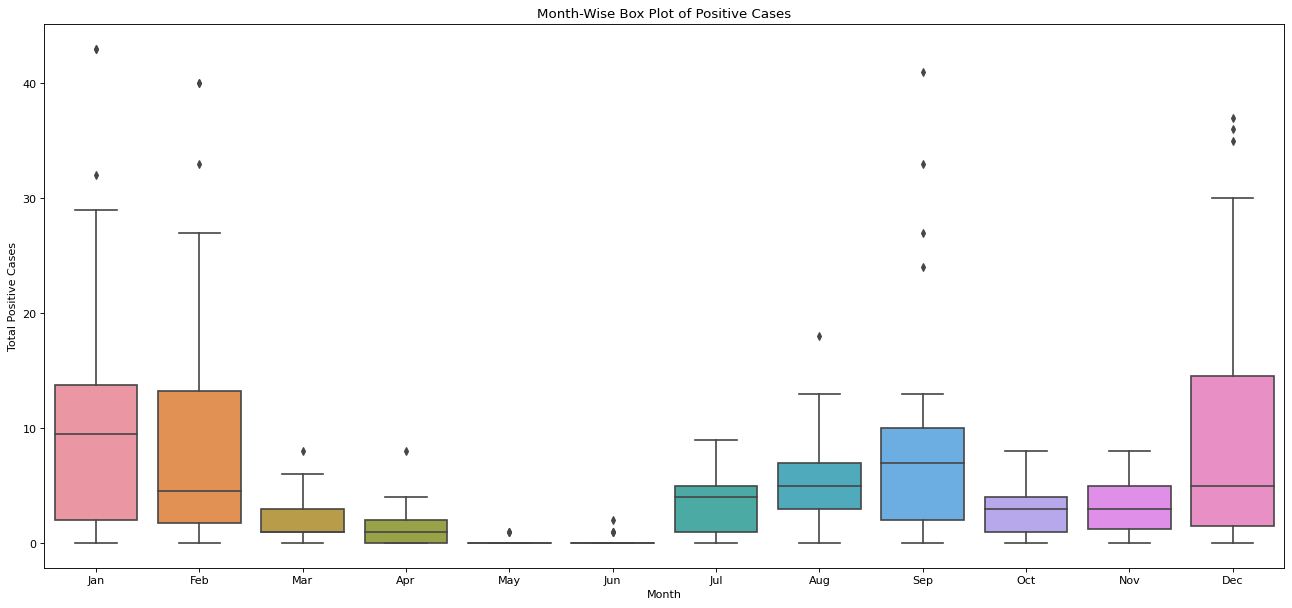

In [30]:
df_case_total_1year['month'] = [d.strftime('%b') for d in df_case_total_1year['Result Date']]

fig, axes = plt.subplots(1, figsize=(20,9), dpi= 80)
sns.boxplot(x='month', y='Total', data=df_case_total_1year, ax = axes)
plt.title("Month-Wise Box Plot of Positive Cases")
plt.xlabel("Month")
plt.ylabel("Total Positive Cases");

# **Predicting Number of Test Collected**

In this section, We want to determine the percentage of people who will go to surveillance, symptoms, and exposure using only the data after fall semester class begin. This is because we want to model the future (October 21,2021 until December 31,2021) using only present data. Present data and past data are different because:
- For past data, Berkeley conducted the class remote. Hence, we assume that only few Berkeley students are in Berkeley area. 
- The way they collected data from the past compared to the present is different (The way that they conduct the test on Saturday and Sunday after the fall semester class begin is different compared to the before fall semester class begin.).

We divided the process into two cases: percentages for weekdays and percentages for weekend. This is because on Saturday and Sunday (weekdays), there is no surveillance test (some of the earlier month has, but assume that there is no surveillance test on Saturday and Sunday). We need to investigate what proportion of people goes through symptoms and exposure test. We can find the proportion by constructing a statistic table for only day Saturday and Sunday, then we can estimate the proportion using the statistic table.

In [31]:
# Combine all three datas
df_collect = pd.concat([df_collect_exp,df_collect_surv,df_collect_sym],axis = 1)

# Remove duplicate column name and some data cleaning
df_collect = df_collect.iloc[:,~df_collect.columns.duplicated()]
df_collect = df_collect[df_collect['Patient Type'] == 'Total']
df_collect = df_collect[['Collection Date','Count Collected Exposure',
                         'Count Collected Surveillance','Count Collected Symptoms']]
df_collect = df_collect[df_collect['Collection Date'] >= "2021-08-18"] # From fall semester class begin
df_collect = df_collect.reset_index().drop(columns = ['index'])

# Computing the total of people tested in all locations
df_collect['Count Total'] = df_collect['Count Collected Exposure'] + \
df_collect['Count Collected Surveillance'] + df_collect['Count Collected Symptoms']

# Concat df_collect with df_case_total
df_collect = df_collect.merge(df_case_total, how = "inner",left_on = "Collection Date", right_on = "Result Date")\
.rename(columns= {'Total':'Positive Total'})
df_collect = df_collect.drop(columns = ['Result Date'])

# Calculate positive rate
df_collect['Positive Rate (%)'] = df_collect['Positive Total']/df_collect['Count Total'] * 100

df_collect

,Collection Date,Count Collected Exposure,Count Collected Surveillance,Count Collected Symptoms,Count Total,Positive Total,Positive Rate (%)
0,2021-08-18,31.0,3733.0,47.0,3811.0,10.0,0.262398
1,2021-08-19,19.0,1661.0,40.0,1720.0,9.0,0.523256
2,2021-08-20,40.0,1796.0,49.0,1885.0,11.0,0.583554
3,2021-08-21,2.0,640.0,22.0,664.0,7.0,1.054217
4,2021-08-22,5.0,1407.0,41.0,1453.0,9.0,0.619408
...,...,...,...,...,...,...,...
58,2021-10-16,12.0,0.0,30.0,42.0,1.0,2.380952
59,2021-10-17,15.0,0.0,32.0,47.0,0.0,0.000000
60,2021-10-18,19.0,1858.0,114.0,1991.0,4.0,0.200904
61,2021-10-19,35.0,1561.0,119.0,1715.0,8.0,0.466472


Now let us add the percentage of:
- Percentage of people who has exposure test
- Percentage of people who has symptoms test
- Percentage of people who has surveillance test \\

These percentages are calculated with respect to the total.


In [32]:
df_collect['Percentage Exposure'] = df_collect['Count Collected Exposure']/df_collect['Count Total'] * 100
df_collect['Percentage Surveillance'] = df_collect['Count Collected Surveillance']/df_collect['Count Total'] * 100
df_collect['Percentage Symptoms'] = df_collect['Count Collected Symptoms']/df_collect['Count Total'] * 100
df_collect.head()

,Collection Date,Count Collected Exposure,Count Collected Surveillance,Count Collected Symptoms,Count Total,Positive Total,Positive Rate (%),Percentage Exposure,Percentage Surveillance,Percentage Symptoms
0,2021-08-18,31.0,3733.0,47.0,3811.0,10.0,0.262398,0.813435,97.953293,1.233272
1,2021-08-19,19.0,1661.0,40.0,1720.0,9.0,0.523256,1.104651,96.569767,2.325581
2,2021-08-20,40.0,1796.0,49.0,1885.0,11.0,0.583554,2.122016,95.278515,2.599469
3,2021-08-21,2.0,640.0,22.0,664.0,7.0,1.054217,0.301205,96.385542,3.313253
4,2021-08-22,5.0,1407.0,41.0,1453.0,9.0,0.619408,0.344116,96.834136,2.821748


Given all these data, let us plot the total number of people that is getting tested. Hover your mouse to the plot for data.

In [33]:
fig_case = px.bar(df_collect, x= 'Collection Date', y = 'Count Total', \
                   title = "Total Testing", 
                  hover_data = df_collect.columns[1:])
fig_case.show()

Now, we split the dataset into `df_collect_weekdays` (only for weekdays) and `df_collect_weekend` (only for weekend).

In [34]:
# Extracting days
df_collect['days'] = df_collect['Collection Date'].dt.day_name()

# Filtering data only for weekdays
weekdays = ['Thursday', 'Friday', 'Monday', 'Tuesday', 'Wednesday']
df_collect_weekdays = df_collect[df_collect["days"].isin(weekdays)].reset_index(drop = True)

# Removing outliers
df_collect_weekdays = df_collect_weekdays[df_collect_weekdays['Positive Rate (%)'] < 33]

# Display statistic table
df_collect_weekdays.describe()

,Count Collected Exposure,Count Collected Surveillance,Count Collected Symptoms,Count Total,Positive Total,Positive Rate (%),Percentage Exposure,Percentage Surveillance,Percentage Symptoms
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,65.068182,1845.613636,136.909091,2047.590909,8.318182,0.413167,3.198604,89.904325,6.897071
std,43.488784,558.625232,52.672228,574.643886,8.620615,0.427875,2.030771,3.913255,2.290511
min,12.000000,1112.000000,40.000000,1232.000000,0.000000,0.000000,0.562324,81.024447,1.233272
25%,28.750000,1524.750000,97.750000,1708.250000,2.000000,0.132370,1.411773,87.395373,5.831570
50%,53.500000,1759.000000,129.500000,1956.500000,6.500000,0.301608,2.829192,90.186437,7.252555
75%,89.000000,1990.750000,181.250000,2217.500000,10.000000,0.488443,4.274152,92.218197,8.256149
max,157.000000,3733.000000,246.000000,3834.000000,41.000000,2.205487,7.741560,97.953293,11.233993


In [35]:
# Filtering data only for Saturday and Sunday
df_collect_weekend = df_collect[(df_collect['days'] == 'Saturday')|(df_collect['days'] == 'Sunday')]\
.reset_index(drop = True)

# Filtering data only for date after fall semester class began
df_collect_weekend = df_collect_weekend.tail(16)

# Display statistic table
df_collect_weekend.describe()

,Count Collected Exposure,Count Collected Surveillance,Count Collected Symptoms,Count Total,Positive Total,Positive Rate (%),Percentage Exposure,Percentage Surveillance,Percentage Symptoms
count,16.000000,16.0,16.000000,16.000000,16.000000,16.000000,16.000000,16.0,16.000000
mean,32.437500,0.0,56.312500,88.750000,1.187500,1.097741,31.527318,0.0,68.472682
std,27.823177,0.0,27.062197,51.944201,1.376893,1.024466,11.408405,0.0,11.408405
min,4.000000,0.0,21.000000,25.000000,0.000000,0.000000,16.000000,0.0,50.746269
25%,11.500000,0.0,31.000000,42.750000,0.000000,0.000000,23.373984,0.0,55.483871
50%,20.500000,0.0,56.500000,80.500000,1.000000,1.113497,28.239203,0.0,71.760797
75%,57.000000,0.0,78.000000,126.500000,2.000000,1.810904,44.516129,0.0,76.626016
max,88.000000,0.0,98.000000,183.000000,5.000000,2.732240,49.253731,0.0,84.000000


## **Modelling distribution of Positive Rate**

In this section, we want to predict the distribution of Positive rate using Q-Q plot for weekdays and weekend. The distribution of Positive Rate then will be used in the next section.

In [36]:
from scipy.stats import norm
from scipy.stats import expon
import pdb
def predict_weekdays_distribution(df,series):
  '''
  Predict weekdays distribution of df series
  '''
    
  # Extract column only for that series
  #pdb.set_trace()
  df = df.loc[:,series]

  # Sort the df_arr
  sample_quantities = np.sort(df)


  # Extract the mean of the series
  mean = df.describe()[1]
  std = df.describe()[2]

  # Computing ppf expon with extracted mean
  # ppf_fun = lambda x: norm.ppf(x, loc = mean, scale = std)
  ppf_fun = lambda x: expon.ppf(x, loc = mean-0.5, scale = std+0.05)

  # Computing percent
  n = len(sample_quantities)
  percent = np.array([i / (n+1) for i in range(1,n+1)])

  # Computing theoritical quantiles
  theoretical_quantiles = ppf_fun(percent)

  return theoretical_quantiles, sample_quantities

from scipy.stats import norm

def predict_weekend_distribution(df,series):
  '''
  Predict distribution of df series
  '''
  # Extract column only for that hour
  df = df.loc[:,series]

  # Sort the df_arr
  sample_quantities = np.sort(df)

  # Extract the mean of the series
  mean = df.describe()[1]
  std = df.describe()[2]

  # Computing ppf normal with extracted mean and std
  ppf_fun = lambda x: norm.ppf(x, loc = mean, scale = std)
  #ppf_fun = lambda x: expon.ppf(x, loc = mean-0.5, scale = std+0.05)

  # Computing percent
  n = len(sample_quantities)
  percent = np.array([i / (n+1) for i in range(1,n+1)])

  # Computing theoritical quantiles
  theoretical_quantiles = ppf_fun(percent)
  
  return theoretical_quantiles, sample_quantities

In [37]:
# Predict distribution weekdays

theoretical_quantiles_1, sample_quantiles_1  = predict_weekdays_distribution(df_collect_weekdays,'Positive Rate (%)')

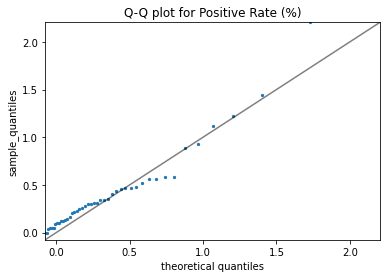

In [38]:
# Plotting Q-Q plot for Positive Rate (%)

plt.scatter(theoretical_quantiles_1,sample_quantiles_1, s= 5)
min_value = min(np.min(theoretical_quantiles_1), np.min(sample_quantiles_1))
max_value = max(np.max(theoretical_quantiles_1), np.max(sample_quantiles_1))
plt.xlim(min_value, max_value)
plt.ylim(min_value, max_value)
plt.plot([min_value, max_value], [min_value, max_value], c='k', alpha=0.5)
plt.title('Q-Q plot for Positive Rate (%)')

# Labelling x-axis and y-axis

plt.xlabel('theoretical quantiles')
plt.ylabel('sample_quantiles');

Distribution weekdays:
- Positive Rate (%): expon.ppf(x, loc = mean-0.5, scale = std+0.05)


In [39]:
# Predict distribution weekend

theoretical_quantiles_1, sample_quantiles_1  = predict_weekend_distribution(df_collect_weekend,'Positive Rate (%)')

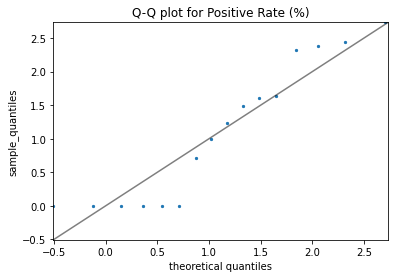

In [40]:
# Plotting Q-Q plot for Positive Rate (%)

plt.scatter(theoretical_quantiles_1,sample_quantiles_1, s= 5)
min_value = min(np.min(theoretical_quantiles_1), np.min(sample_quantiles_1))
max_value = max(np.max(theoretical_quantiles_1), np.max(sample_quantiles_1))
plt.xlim(min_value, max_value)
plt.ylim(min_value, max_value)
plt.plot([min_value, max_value], [min_value, max_value], c='k', alpha=0.5)
plt.title('Q-Q plot for Positive Rate (%)')

# Labelling x-axis and y-axis

plt.xlabel('theoretical quantiles')
plt.ylabel('sample_quantiles');

Distribution of weekdays:
- Assume Posiive Rate have normal distribution with mean and std. Not enough data to deduce much from the Q-Q plot. 

## **Predict using posterior distribution**

Now, to predict the number of people who will get tested, we will use the positive rate and the number of people in the future who are tested positive. In other words,
$$\textrm{# Tested Positive} = \textrm{# Number of test} \cdot \textrm{Positive Rate (%)}$$
\
$$\textrm{# Number of test Future} =  \frac{\textrm{# Tested Positive Future}}{\textrm{Positive Rate Future(%)}} $$


In the code below, we apply the distribution of the Positive Rate (%) from the previous section.

In [41]:
np.random.seed(seed = 88) # For reproducibility purposes

# Predicting percentage number of people who are tested positive
# Until December 31,2021
mean_weekday = df_collect_weekdays['Positive Rate (%)'].describe()[1]
std_weekday = df_collect_weekdays['Positive Rate (%)'].describe()[2]
mean_weekend = df_collect_weekend['Positive Rate (%)'].describe()[1]
std_weekend = df_collect_weekend['Positive Rate (%)'].describe()[2]

# Initiating list 
df_case_forecast['days'] = df_case_forecast['Result Date'].dt.day_name()
weekdays = ['Thursday', 'Friday', 'Monday', 'Tuesday', 'Wednesday']
weekend = ['Saturday','Sunday']
future_percentage_positive = []

# Sample positive rate using uniform distribution according to day
for day in df_case_forecast['days']:
  # Max is the maximum number from statistic table
  if day in weekdays:
    f_percent = min(max(expon.rvs(loc = mean_weekday, scale = std_weekday),0),2.205487)
    future_percentage_positive.append(f_percent)
  if day in weekend:
    f_percent = min(max(np.random.normal(loc = mean_weekend, scale = std_weekend),0),2.732240)
    future_percentage_positive.append(f_percent)    

# Predicting number of people tested 
count_total_list = []
i = 0
for day in df_case_forecast['days']:
  if day in weekdays:
    count_total = df_case_forecast['Total'][i]/future_percentage_positive[i] * 100
    count_total = np.round(count_total)
    count_total_list.append(count_total)
    i += 1
    continue
  # Restricting count_total_list to only 25 min and 180 max for Saturday and Sunday
  if day in weekend:
    count_total = df_case_forecast['Total'][i]/future_percentage_positive[i] * 100
    count_total = np.round(count_total)
    count_total_list.append(count_total)
    i += 1
    continue
  
# Replace nan and inf with zero

count_total_list = np.nan_to_num(count_total_list, posinf = 0)
count_total_list = np.where(count_total_list > 10000,750,count_total_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning:

invalid value encountered in double_scalars



Now, let us compute the number of people for each test for each day using the percentages that we already define.

In [42]:
# Defining parameters
percent_surv_weekdays = 90 / 100
percent_sym_weekdays = 7 / 100
percent_exp_weekdays = 3 / 100
percent_surv_weekend = 0
percent_sym_weekend = 72 / 100
percent_exp_weekend = 28 /100

# Initiating list
count_surv_list = []
count_exp_list = []
count_sym_list = []
d = 0

# Computing number of people for each test for each day
for day in df_case_forecast['days']:
  if day in weekend: # in weekend
    # Surveillance
    count_surv = count_total_list[d] * percent_surv_weekend
    count_surv_list.append(count_surv)
    # Symptoms
    count_sym = count_total_list[d] * percent_sym_weekend
    count_sym_list.append(count_sym)
    # Exposure
    count_exp = count_total_list[d] * percent_exp_weekend
    count_exp_list.append(count_exp)
    # Next day
    d += 1
    continue
  if day in weekdays: # in weekdays
    # Surveillance
    count_surv = count_total_list[d] * percent_surv_weekdays
    count_surv_list.append(count_surv)
    # Symptoms
    count_sym = count_total_list[d] * percent_sym_weekdays
    count_sym_list.append(count_sym)
    # Exposure
    count_exp = count_total_list[d] * percent_exp_weekdays
    count_exp_list.append(count_exp)
    # Next day
    d += 1
    continue

#-----------
# Finish loop
#-----------

# Round result
count_surv_list = np.round(count_surv_list)
count_sym_list = np.round(count_sym_list)
count_exp_list = np.round(count_exp_list)

# After rounding, making the data consistent by adding or substracting count_surv_list
for i in range(len(count_total_list)):
  if count_total_list[i] == count_surv_list[i] + count_sym_list[i] + count_exp_list[i]:
    continue
  if count_total_list[i] < count_surv_list[i] + count_sym_list[i] + count_exp_list[i]:
    while count_total_list[i] < count_surv_list[i] + count_sym_list[i] + count_exp_list[i]:
      count_surv_list[i] = count_surv_list[i] - 1
  if count_total_list[i] > count_surv_list[i] + count_sym_list[i] + count_exp_list[i]:
    while count_total_list[i] > count_surv_list[i] + count_sym_list[i] + count_exp_list[i]:
      count_surv_list[i] = count_surv_list[i] + 1

# Check if each value after rounding match with the total
print("Round Match: ", all(count_total_list == count_surv_list + count_sym_list + count_exp_list))

Round Match:  True


We make a forecast Dataframe, then we concatenate the real DataFrame with forecast DataFrame.

In [43]:
# Make a forecast DataFrame

positive_rate_list = future_percentage_positive
percent_exp_list = np.multiply(count_exp_list/count_total_list , 100)
percent_surv_list = np.multiply(count_surv_list/count_total_list , 100)
percent_sym_list = np.multiply(count_sym_list/count_total_list , 100)

d_forecast = {'Collection Date':df_case_forecast['Result Date'],
              'Count Collected Exposure':count_exp_list,
              'Count Collected Surveillance':count_surv_list,
              'Count Collected Symptoms':count_sym_list,
              'Count Total':count_total_list,
              'Positive Total':df_case_forecast['Total'],
              'Positive Rate (%)':positive_rate_list,
              'Percentage Exposure':percent_exp_list,
              'Percentage Surveillance':percent_surv_list,
              'Percentage Symptoms': percent_sym_list
              }

df_collect_forecast = pd.DataFrame(data = d_forecast )
df_collect_forecast.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning:

invalid value encountered in true_divide



,Collection Date,Count Collected Exposure,Count Collected Surveillance,Count Collected Symptoms,Count Total,Positive Total,Positive Rate (%),Percentage Exposure,Percentage Surveillance,Percentage Symptoms
0,2021-10-21,17.0,524.0,41.0,582.0,5,0.859377,2.920962,90.034364,7.044674
1,2021-10-22,17.0,503.0,39.0,559.0,4,0.715910,3.041145,89.982111,6.976744
2,2021-10-23,40.0,0.0,104.0,144.0,3,2.077707,27.777778,0.000000,72.222222
3,2021-10-24,72.0,0.0,185.0,257.0,3,1.167826,28.015564,0.000000,71.984436
4,2021-10-25,10.0,290.0,23.0,323.0,3,0.928305,3.095975,89.783282,7.120743


In [44]:
# Concat real dataframe with forecast dataframe

df_collect_fall = pd.concat([df_collect,df_collect_forecast]).reset_index(drop=True)
df_collect_fall['days'] = df_collect_fall['Collection Date'].dt.day_name()
df_collect_fall.head()

,Collection Date,Count Collected Exposure,Count Collected Surveillance,Count Collected Symptoms,Count Total,Positive Total,Positive Rate (%),Percentage Exposure,Percentage Surveillance,Percentage Symptoms,days
0,2021-08-18,31.0,3733.0,47.0,3811.0,10,0.262398,0.813435,97.953293,1.233272,Wednesday
1,2021-08-19,19.0,1661.0,40.0,1720.0,9,0.523256,1.104651,96.569767,2.325581,Thursday
2,2021-08-20,40.0,1796.0,49.0,1885.0,11,0.583554,2.122016,95.278515,2.599469,Friday
3,2021-08-21,2.0,640.0,22.0,664.0,7,1.054217,0.301205,96.385542,3.313253,Saturday
4,2021-08-22,5.0,1407.0,41.0,1453.0,9,0.619408,0.344116,96.834136,2.821748,Sunday


Now, we want to concatenate the data for after the fall class semester begin with the remaining data.

In [45]:
# Combine all three datas
df_collect = pd.concat([df_collect_exp,df_collect_surv,df_collect_sym],axis = 1)

# Remove duplicate column name and some data cleaning
df_collect = df_collect.iloc[:,~df_collect.columns.duplicated()]
df_collect = df_collect[df_collect['Patient Type'] == 'Total']
df_collect = df_collect[['Collection Date','Count Collected Exposure',
                         'Count Collected Surveillance','Count Collected Symptoms']]
df_collect = df_collect[(df_collect['Collection Date'] >= "2021-01-05") & (df_collect['Collection Date'] < "2021-08-18")] 
df_collect = df_collect.reset_index().drop(columns = ['index'])

# Computing the total of people tested in all locations
df_collect['Count Total'] = df_collect['Count Collected Exposure'] + \
df_collect['Count Collected Surveillance'] + df_collect['Count Collected Symptoms']

# Concat df_collect with df_case_total
df_collect = df_collect.merge(df_case_total, how = "inner",left_on = "Collection Date", right_on = "Result Date")\
.rename(columns= {'Total':'Positive Total'})
df_collect = df_collect.drop(columns = ['Result Date'])

# Calculate percentages
df_collect['Positive Rate (%)'] = df_collect['Positive Total']/df_collect['Count Total'] * 100
df_collect['Percentage Exposure'] = df_collect['Count Collected Exposure']/df_collect['Count Total'] * 100
df_collect['Percentage Surveillance'] = df_collect['Count Collected Surveillance']/df_collect['Count Total'] * 100
df_collect['Percentage Symptoms'] = df_collect['Count Collected Symptoms']/df_collect['Count Total'] * 100

# day name 
df_collect['days'] = df_collect['Collection Date'].dt.day_name()

# Concatenate data to form 1 year data
df_collect_total_1year = pd.concat([df_collect,df_collect_fall]).reset_index(drop=True)
df_collect_total_1year

,Collection Date,Count Collected Exposure,Count Collected Surveillance,Count Collected Symptoms,Count Total,Positive Total,Positive Rate (%),Percentage Exposure,Percentage Surveillance,Percentage Symptoms,days
0,2021-01-05,25.0,1588.0,79.0,1692.0,1,0.059102,1.477541,93.853428,4.669031,Tuesday
1,2021-01-06,5.0,728.0,38.0,771.0,11,1.426719,0.648508,94.422827,4.928664,Wednesday
2,2021-01-07,7.0,580.0,29.0,616.0,13,2.110390,1.136364,94.155844,4.707792,Thursday
3,2021-01-08,22.0,718.0,26.0,766.0,14,1.827676,2.872063,93.733681,3.394256,Friday
4,2021-01-11,33.0,1411.0,54.0,1498.0,1,0.066756,2.202937,94.192256,3.604806,Monday
...,...,...,...,...,...,...,...,...,...,...,...
314,2021-12-27,175.0,5248.0,408.0,5831.0,25,0.428715,3.001200,90.001715,6.997085,Monday
315,2021-12-28,133.0,3978.0,309.0,4420.0,21,0.475063,3.009050,90.000000,6.990950,Tuesday
316,2021-12-29,128.0,3838.0,299.0,4265.0,36,0.844141,3.001172,89.988277,7.010551,Wednesday
317,2021-12-30,48.0,1447.0,113.0,1608.0,25,1.554380,2.985075,89.987562,7.027363,Thursday


We plot the data for 1 year, starting from January 1,2021 to December, 31 2021. Hover your mouse to the plot for data.

In [46]:
fig_case_1year = px.bar(df_collect_total_1year, x= 'Collection Date', y = 'Count Total', \
                   title = "Total Testing", 
                  hover_data = df_collect_total_1year.columns[1:])
fig_case_1year.show()

Thus, we sucessfully predict the number of people getting tested for each kind of test.

# **Data for Simio**

In [47]:
# Displaying data

df_collect_total_1year.head()

,Collection Date,Count Collected Exposure,Count Collected Surveillance,Count Collected Symptoms,Count Total,Positive Total,Positive Rate (%),Percentage Exposure,Percentage Surveillance,Percentage Symptoms,days
0,2021-01-05,25.0,1588.0,79.0,1692.0,1,0.059102,1.477541,93.853428,4.669031,Tuesday
1,2021-01-06,5.0,728.0,38.0,771.0,11,1.426719,0.648508,94.422827,4.928664,Wednesday
2,2021-01-07,7.0,580.0,29.0,616.0,13,2.110390,1.136364,94.155844,4.707792,Thursday
3,2021-01-08,22.0,718.0,26.0,766.0,14,1.827676,2.872063,93.733681,3.394256,Friday
4,2021-01-11,33.0,1411.0,54.0,1498.0,1,0.066756,2.202937,94.192256,3.604806,Monday


The dataframe below is for the stopping arrival condition in simio for each day. In simio, we want to only simuulate from future dataframe.

In [55]:
# Constructing dataframe for simio for surveillance testing

df_surv = df_collect_total_1year[['Collection Date','Count Collected Surveillance']]
df_surv = df_surv[df_surv['Collection Date'] >= '2021-10-21'].reset_index(drop = True)
df_surv.head()

,Collection Date,Count Collected Surveillance
0,2021-10-21,524.0
1,2021-10-22,503.0
2,2021-10-23,0.0
3,2021-10-24,0.0
4,2021-10-25,290.0


In [56]:
# Constructing dataframe for simio for exposure + symptoms testing

df_expsym = df_collect_total_1year.copy()
df_expsym['Count Collected Exp + Sym'] = df_expsym['Count Collected Exposure'] + df_expsym['Count Collected Symptoms']
df_expsym = df_expsym[['Collection Date','Count Collected Exp + Sym']]
df_expsym = df_expsym[df_expsym['Collection Date'] >= '2021-10-21'].reset_index(drop = True)
df_expsym.head()

,Collection Date,Count Collected Exp + Sym
0,2021-10-21,58.0
1,2021-10-22,56.0
2,2021-10-23,144.0
3,2021-10-24,257.0
4,2021-10-25,33.0
